# 散乱のデータの読み込み ＆ 距離ごとにdataframeを作成

In [16]:
%%time
# import系
import time
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score,  mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy import signal
import statsmodels.formula.api as smf
import statsmodels.api as sm

from estimation_func import linear_model


# 散乱データ、硬さデータimport, distance除く
total_df = pd.read_excel('./../data/2020_さんふじ_レーザー.xlsx')

# 距離の部分のみを削除
distance = total_df.iloc[:,0]
apple_df = total_df.drop('distance(cm)',axis=1)

# 硬さ
firmness_all = pd.read_excel('./../data/2020_さんふじ_硬さ.xlsx',index_col=0)
firmness_all = 9.81*firmness_all # kgからNに変換

CPU times: user 20.7 s, sys: 203 ms, total: 20.9 s
Wall time: 20.9 s


In [2]:
%%time
# 3 mm以前は不安定なので除去、念のため4mm以降の場合も作成
# curve fittingするときに 0.3 cmのとこはいらないので、削除

distance_3mm = distance[240:]
apple_df_3mm = apple_df[240:]
distance_4mm = distance[404:]
apple_df_4mm = distance[404:]

# ↓↓↓↓↓appendix↓↓↓↓↓
# 同じ名前のオブジェクトなので、実行は一回のみ
# distance = distance[240:]
# apple_df = apple_df[240:]

CPU times: user 218 µs, sys: 38 µs, total: 256 µs
Wall time: 262 µs


# 15 mmまでのdataframeと35 mmまでのdataframeを作成

In [3]:
%%time
# distanceを分割
distance_3mm_11mm = distance_3mm[distance_3mm <= 1.601]
distance_3mm_36mm = distance_3mm[distance_3mm <= 3.61]
distance_4mm_11mm = distance_4mm[distance_4mm <= 1.601]
distance_4mm_36mm = distance_4mm[distance_4mm <= 3.61]

apple_df_3mm_11mm = apple_df.iloc[distance_3mm_11mm.index,:]
apple_df_3mm_36mm = apple_df.iloc[distance_3mm_36mm.index,:]
apple_df_4mm_11mm = apple_df.iloc[distance_4mm_11mm.index,:]
apple_df_4mm_36mm = apple_df.iloc[distance_4mm_36mm.index,:]

# temp_11 = distance_3mm_11mm
# temp_11.index = apple_df_3mm_11mm.index
# temp_36 = distance_3mm_36mm
# temp_36.index = apple_df_3mm_36mm.index
# pd.concat([temp_11,apple_df_3mm_11mm],axis=1).to_csv('profile_3mm_11mm.csv')
# pd.concat([temp_36,apple_df_3mm_36mm],axis=1).to_csv('profile_3mm_36mm.csv')

CPU times: user 9.21 ms, sys: 6.48 ms, total: 15.7 ms
Wall time: 15.4 ms


# 平滑化、fittingおよび変化率 を行う関数を作成

In [4]:
# 平滑化
# fitting
# 変化率
# の順で行う関数作成

def smooth_fitting_diff_func(distance, data, num):
    '''
    numは3mmスタートは3, 4mmスタートは4を入力
    返り値：平滑化の結果、fitting係数と変化率のdataframe
    '''
    #####平滑化とfittingを同時に#####

    # fittingする関数を定義
    def func_poly(x,a,b):
        y = -2 * np.log10(x) - a*x + b
        return y
    
    # 空の集合
    sg_total = pd.DataFrame()
    eff_df = pd.DataFrame()
    
    # 同時に行いそれぞれに格納
    for i in range(data.shape[1]):
        sg_i = pd.Series(signal.savgol_filter(data.iloc[:,i],201,1))
        eff,cov = curve_fit(func_poly,distance,sg_i,maxfev=20000)
        eff_i = pd.DataFrame(eff)
        # fitting係数を格納
        eff_df = pd.concat([eff_df,eff_i],axis=1)
        #平滑化処理の結果を格納
        sg_total = pd.concat([sg_total,sg_i],axis=1)
    sg_total.columns = data.columns
    eff_df.index = ['a', 'b']
    eff_df.columns = data.columns
    eff_df = eff_df.T
    
    #####変化率#####
    
    # 1 mm間隔のindexを算出し、それらのindex間で変化率を求める
    # 最後に11 mmと36 mm用で分ける
    
    differential_value_j = []
    width = 0.1
    num = num+1
    
    if num == 4:
        temp=240
    else:
        temp=404
    
    # 11 mmと36 mmで場合分け
    # 11 mmのときは2593
    if distance.index[-1] == 5232:
        max_distance = int(16/(width*10))
        # width(cm)ずつのdistanceのindexを作成　-> 変化率に利用
        distance_width = [distance[distance > ((i+num)/10)].index[0] - temp for i in range(max_distance-num+1)]
    else:
        max_distance = int(36/(width*10))
        # width(cm)ずつのdistanceのindexを作成　-> 変化率に利用
        distance_width = [distance[distance > ((i+num)/10)].index[0] - temp for i in range(max_distance-num+1)]
    
    # 変化率の計算
    diff_df = pd.DataFrame()
    for i in range(len(distance_width) - 1):
        diff_temp = pd.DataFrame(sg_total.iloc[distance_width[i+1],:] - sg_total.iloc[distance_width[i],:])
        diff_temp.columns = [f'diff_{i+num}mm']
        diff_df = pd.concat([diff_df,diff_temp],axis=1)
        
    # 変化率と係数を統一
    feature_df = pd.concat([eff_df, diff_df],axis=1)
    
    return sg_total, feature_df

# 特徴量の作成(変化率＋係数)

In [5]:
%%time
temp_3_11 = smooth_fitting_diff_func(distance_3mm_11mm,apple_df_3mm_11mm,num=3)
temp_3_36 = smooth_fitting_diff_func(distance_3mm_36mm,apple_df_3mm_36mm,num=3)
feature_3mm_11mm = temp_3_11[1]
feature_3mm_36mm = temp_3_36[1]

# sg_totalを保存
temp_11 = distance_3mm_11mm
temp_11.index = temp_3_11[0].index
temp_36 = distance_3mm_36mm
temp_36.index = temp_3_36[0].index
pd.concat([temp_11,temp_3_11[0]],axis=1).to_csv('./../data/profile_sg_3mm_11mm.csv')
pd.concat([temp_36,temp_3_36[0]],axis=1).to_csv('./../data/profile_sg_3mm_36mm.csv')

CPU times: user 3.94 s, sys: 681 ms, total: 4.62 s
Wall time: 4.63 s


# 説明変数の標準化

In [7]:
%%time
# 標準化の関数
def scaler(feature):
    scaler = StandardScaler()
    feature_temp = pd.DataFrame(scaler.fit_transform(feature))
    feature_temp.columns = feature.columns
    feature_temp.index = feature.index
    
    return feature_temp

feature_3mm_11mm_scale = scaler(feature_3mm_11mm)
feature_3mm_36mm_scale = scaler(feature_3mm_36mm)

feature_3mm_11mm_scale.to_csv('./../data/feature_3mm_11mm_scale.csv')
feature_3mm_36mm_scale.to_csv('./../data/feature_3mm_36mm_scale.csv')

CPU times: user 10.1 ms, sys: 2.5 ms, total: 12.6 ms
Wall time: 11.6 ms


# 線形重回帰(任意の貯蔵期間モデル, 全サンプル使用)

In [18]:
model_3mm_11mm_6week_pred_coef = linear_model(feature_3mm_11mm_scale,firmness_all,6)
model_3mm_11mm_7week_pred_coef = linear_model(feature_3mm_11mm_scale,firmness_all,7)
model_3mm_36mm_6week_pred_coef = linear_model(feature_3mm_36mm_scale,firmness_all,6)
model_3mm_36mm_7week_pred_coef = linear_model(feature_3mm_36mm_scale,firmness_all,7)
model_3mm_36mm_6week_ab_pred_coef = linear_model(feature_3mm_36mm_scale[['a', 'b']],firmness_all,6)

# 精度評価(重相関係数とRMSE全サンプルモデル)

In [28]:
# 精度評価の指標を算出する関数

def r_rmse(model):
    '''
    入力値：y_act, y_predが格納されたdataframe
    返り値：R, RMSEが格納されたdataframe
    '''
    # 重相関係数
    r_temp = round(model.corr().iloc[0,1],3)

    # RMSE
    mse_temp = mean_squared_error(model['Actual'], model['Predict'])
    rmse_temp = round(np.sqrt(mse_temp),3)

    return pd.DataFrame([r_temp,rmse_temp],index = ['R', 'RMSE'])


In [29]:
model_all_list = [model_3mm_11mm_6week_pred_coef,model_3mm_36mm_6week_pred_coef,
                  model_3mm_11mm_7week_pred_coef,model_3mm_36mm_7week_pred_coef]

r_rmse_all_df = pd.DataFrame()
for model_i in model_all_list:
    df_temp = r_rmse(model_i)
    r_rmse_all_df = pd.concat([r_rmse_all_df,df_temp],axis=1)
r_rmse_all_df.columns = ['model_3mm_11mm_6week','model_3mm_36mm_6week',
                         'model_3mm_11mm_7week','model_3mm_36mm_7week']

In [30]:
r_rmse_all_df

,model_3mm_11mm_6week,model_3mm_36mm_6week,model_3mm_11mm_7week,model_3mm_36mm_7week
R,0.585,0.691,0.546,0.643
RMSE,1.293,1.152,1.587,1.450


## 結果：3 mm以降の解析を行い、3mm_11mm_6,7weekと3mm_36mm_6,7weekで比較する

# Hold Out法

In [31]:
temp = np.array([np.random.choice(index_temp[i],size=1) for i in range(7)]).flatten()
temp = [f'{temp[i]}_' for i in range(7)]

ind = []
for j in range(7):
    for i in feature_3mm_11mm_scale.index:
        if temp[j] in i:
            ind.append(i)

ind

NameError: name 'index_temp' is not defined

In [33]:
def holdout(feature,sample, random):
    '''
    feature: 特徴量
    sample : '_1_'などで定義
    random : 0はある番号を一括、1はrandomで選択、2は自分でサンプル指定
    '''
    # 全indexを抽出
    index_temp = []
    for period in range(7):
        for num in [str(num+1) for num in range(5)]:
            index_temp.append(f'{period}_{num}')
            
    # 配列に変換
    temp = np.array(index_temp)
    index_temp = temp.reshape(7,5)
    
    # test用のindexを抽出
    if random == 0:
        feature = feature.iloc[:140,:]
        test_index = [i for i in feature.index if sample in i]
        train_index = feature.index.drop(test_index)
        
    elif random == 1:
        feature = feature.iloc[:140,:]
        # 前処理
        temp = np.array([np.random.choice(index_temp[i],size=1) for i in range(7)]).flatten()
        temp = [f'{temp[i]}_' for i in range(7)]
        
        test_index= []
        for j in range(7):
            for i in feature.index:
                if temp[j] in i:
                    test_index.append(i)
        train_index = feature.index.drop(test_index)
        
    else:
        feature = feature.iloc[:140,:]
        test_index = ind1
        train_index = feature.index.drop(test_index)
    
    # 各貯蔵期間ごとに5つのリンゴを使うが、4つをtrain, 1つをtestのhold-outを行う
    X_train = feature.loc[train_index,:]
    X_test = feature.loc[test_index,:]

    target = firmness_all.iloc[:140,:]
    y_train = target.loc[train_index,:]
    y_test = target.loc[test_index,:]

    linear = LinearRegression()
    model = linear.fit(X_train,y_train)
    y_pred = pd.DataFrame(model.predict(X_test),index=y_test.index,columns=y_test.columns)
    y_pred_real = pd.DataFrame(model.predict(X_train),index=y_train.index,columns=y_train.columns)

    rscore_list_kf = []
    rmse_list_kf = []
    rscore_list_kf.append(pd.concat([y_test,y_pred],axis=1).corr().iloc[0,1])
    rmse_list_kf.append(np.sqrt(mean_squared_error(y_test,y_pred)))
    
    # 描写
    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(1, 1, 1)
    y_real = y_test.values.flatten()
    y_pred = y_pred.values.flatten()
    
    ax1.scatter(y_train, model.predict(X_train).ravel(),c='b',label='training',s=100)
    ax1.scatter(y_test,   y_pred,c='r',label='test',s=100)
    ax1.text(0.01,0.85,f'R_test: {np.corrcoef(y_real, y_pred)[1,0]:.3f}\nRMSE_test : {np.sqrt(mean_squared_error(y_real,y_pred)):.3f}',
             transform=ax1.transAxes,size=28)

    ax1.plot([0,28],[0,28],c='k',label='y=x')
    ax1.plot([0,28],[3.3,31.3],linestyle='dashed',c='gray')
    ax1.plot([0,28],[-3.3,24.7],linestyle='dashed',c='gray')
    ax1.set_ylabel('Predicted Firmness (N)',fontsize=32)
    ax1.set_xlabel('Measured  Firmness (N)',fontsize=32)
    ax1.set_xticklabels([18,20,22,24,26,28],fontsize=28)
    ax1.set_yticklabels([18,20,22,24,26,28],fontsize=28)
    ax1.set_xlim([18, 28])
    ax1.set_ylim([18, 28])
    ax1.grid(True)
    ax1.legend(loc ='lower right',fontsize=28,frameon=False)
    
#     if feature.columns[-1][5:] == '15mm':
#         ax1.set_title('6-week-storage-15mm model', fontsize=28)
#     else:
#         ax1.set_title('6-week-storage model', fontsize=28)

    if feature.columns[-1][5:] == '15mm':
        ax1.text(0.01,0.95,'a)',  transform=ax1.transAxes, fontsize=28)
    else:
        ax1.text(0.01,0.95,'b)',  transform=ax1.transAxes, fontsize=28)
    
    fig.savefig(f'result_compare/fig_{feature.columns[-1][5:]}.jpg')
    
    return rscore_list_kf, rmse_list_kf, test_index

/var/folders/19/rctt2t_j609blszmcrd_zd4r0000gn/T/ipykernel_31670/2173153233.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([18,20,22,24,26,28],fontsize=28)
/var/folders/19/rctt2t_j609blszmcrd_zd4r0000gn/T/ipykernel_31670/2173153233.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([18,20,22,24,26,28],fontsize=28)


FileNotFoundError: [Errno 2] No such file or directory: 'result_compare/fig_15mm.jpg'

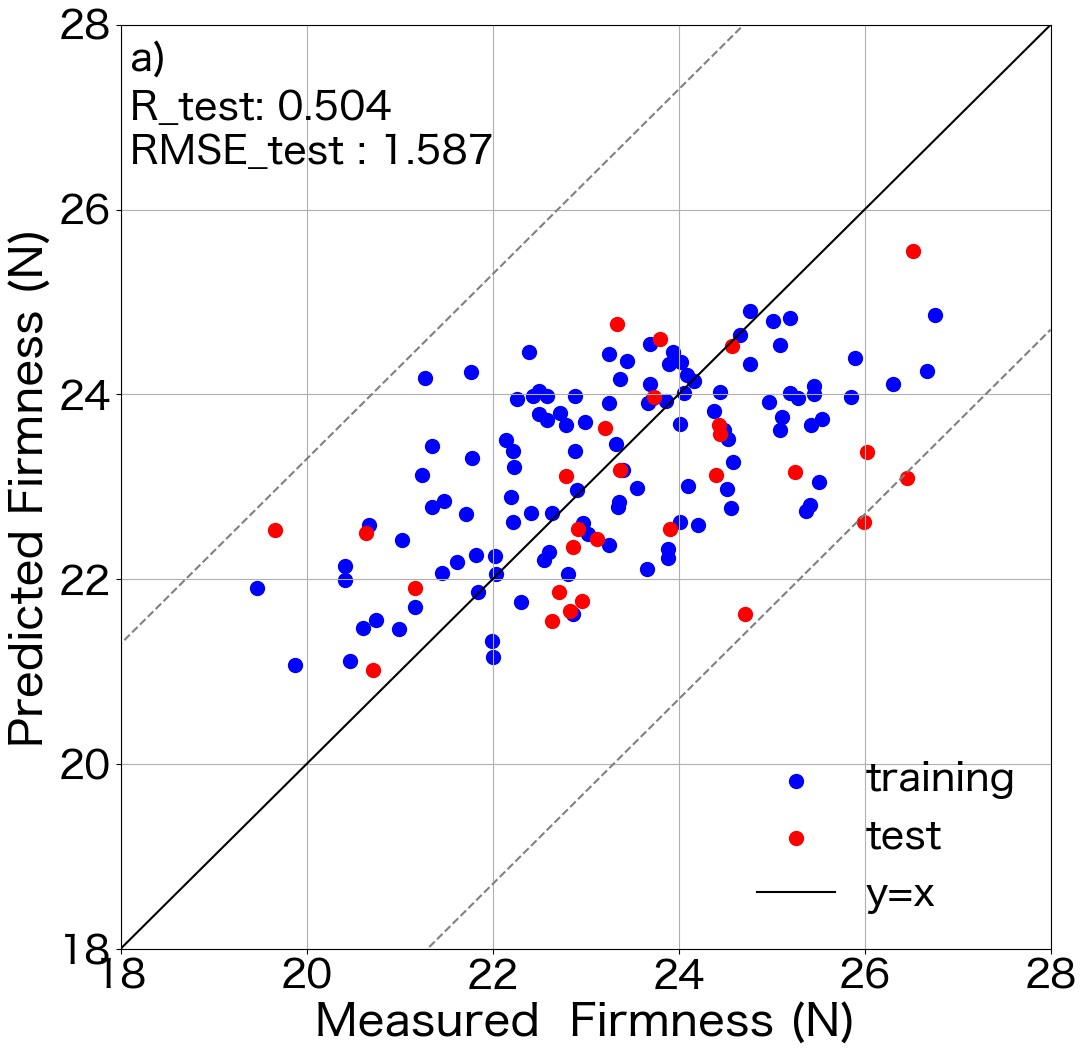

In [34]:
# holdout法
ind1 = ['0_1_1','0_1_2','0_1_3','0_1_4','1_1_1','1_1_2','1_1_3','1_1_4','2_4_1','2_4_2','2_4_3','2_4_4','3_1_1','3_1_2','3_1_3','3_1_4','4_3_1','4_3_2','4_3_3','4_3_4','5_2_1','5_2_2','5_2_3','5_2_4','6_5_1','6_5_2','6_5_3','6_5_4']

temp = '_1_'
temp_11  = holdout(feature_3mm_11mm_scale,sample=temp,random=2)
temp_all = holdout(feature_3mm_36mm_scale,sample=temp,random=2)

print('3mm_15mm', temp_11[0])

print('3mm_36mm', temp_all[0])

import cv2
im1 = cv2.imread('result_compare/fig_15mm.jpg')
im2 = cv2.imread('result_compare/fig_35mm.jpg')
im_h = cv2.hconcat([im1, im2])
cv2.imwrite('result_compare/fig_compare.jpg', im_h)

# CV結果

In [20]:
feature_train, feature_test, target_train, target_test = train_test_split(feature_3mm_36mm_scale, 
                                                                          firmness_all, 
                                                                          test_size = 0.2)

In [64]:
def kfold_apple(feature, target, storage_week, num):
    '''
    kfoldで精度評価
    '''
    kf = KFold(n_splits=5,shuffle=True, random_state=num)
    
    if storage_week == 6:
        feature = feature.iloc[:140,:]
        target = target.iloc[:140,:]
     
    feature_train, feature_test, target_train, target_test = train_test_split(feature, target, test_size = 0.2, random_state=num)
    
    rscore_list_kf = []
    rmse_list_kf = []
    
    # 各foldの実測値と予測値を格納する -> [[['1-実測値'],['1-予測値']], [['2-実測値'],['2-予測値']], ...]
    target_fold = []
    for cali_index, vali_index in kf.split(feature):
        X_train,y_train = feature.iloc[cali_index,:],target.iloc[cali_index]
        X_test, y_test = feature.iloc[vali_index,:],target.iloc[vali_index]
        linear = LinearRegression()
        model = linear.fit(X_train,y_train)
        y_pred = pd.DataFrame(model.predict(X_test),index=y_test.index,columns=y_test.columns)
        y_pred_real = pd.DataFrame(model.predict(X_train),index=y_train.index,columns=y_train.columns)

        rscore_list_kf.append(pd.concat([y_test,y_pred],axis=1).corr().iloc[0,1])
        rmse_list_kf.append(np.sqrt(mean_squared_error(y_test,y_pred)))
        
        # 実測値と予測値を格納
        y_pred_real = pd.concat([y_train, y_pred_real],axis=1)
        y_pred = pd.concat([y_test, y_pred],axis=1)
        target_fold.append(y_pred_real)
        target_fold.append(y_pred)
    
#     print(f'R_validation : {np.mean(rscore_list_kf):.2f} +- {np.std(rscore_list_kf):.2f}')
#     print(f'RMSE_validation : {np.mean(rmse_list_kf):.2f} +- {np.std(rmse_list_kf):.2f}')

    temp = pd.DataFrame([f'{np.mean(rscore_list_kf):.3f} +- {np.std(rscore_list_kf):.3f}',
                         f'{np.mean(rmse_list_kf):.3f} +- {np.std(rmse_list_kf):.3f}'],
                         index = ['R','RMSE'])
    temp = temp.T
    
    return rscore_list_kf, rmse_list_kf, temp, target_fold

# 224879

In [65]:
# %%time
# temp_lst = []
# for i in range(600000,1000000):
#     temp = kfold_apple(feature_3mm_36mm_scale, firmness_all, storage_week=6, num=i)[1]
#     temp_lst.append(np.mean(temp))


# print(f'index : {temp_lst.index(np.min(temp_lst))}')
# print(f'min   : {np.min(temp_lst)}')

# # △ 4898   1.4020
# # ×127655 1.3836
# # △470164 1.3812
# # 〇560415 1.399
# # ×138832 1.3855

In [66]:
a = 560415
model_3mm_11mm_6week = kfold_apple(feature_3mm_11mm_scale, firmness_all, storage_week=6, num=a)
model_3mm_11mm_7week = kfold_apple(feature_3mm_11mm_scale, firmness_all, storage_week=7, num=a)
model_3mm_36mm_6week = kfold_apple(feature_3mm_36mm_scale, firmness_all, storage_week=6, num=a)
model_3mm_36mm_7week = kfold_apple(feature_3mm_36mm_scale, firmness_all, storage_week=7, num=a)

model_CV_result = pd.concat([model_3mm_11mm_6week[2],
                             model_3mm_11mm_7week[2],
                             model_3mm_36mm_6week[2],
                             model_3mm_36mm_7week[2]],
                            axis=0)
model_CV_result.index = ['model_3mm_11mm_6week','model_3mm_11mm_7week','model_3mm_36mm_6week','model_3mm_36mm_7week']

In [35]:
model_CV_result

# linear
# 	R	RMSE
# model_3mm_11mm_6week	0.46 +- 0.06	1.42 +- 0.06
# model_3mm_11mm_7week	0.44 +- 0.08	1.74 +- 0.11
# model_3mm_36mm_6week	0.53 +- 0.10	1.38 +- 0.15
# model_3mm_36mm_7week	0.36 +- 0.06	1.90 +- 0.14

# lasso


# ridge

,R,RMSE
model_3mm_11mm_6week,0.485 +- 0.073,1.448 +- 0.164
model_3mm_11mm_7week,0.437 +- 0.094,1.732 +- 0.146
model_3mm_36mm_6week,0.553 +- 0.077,1.399 +- 0.119
model_3mm_36mm_7week,0.337 +- 0.140,1.977 +- 0.161


# 回帰係数プロット

<AxesSubplot:>

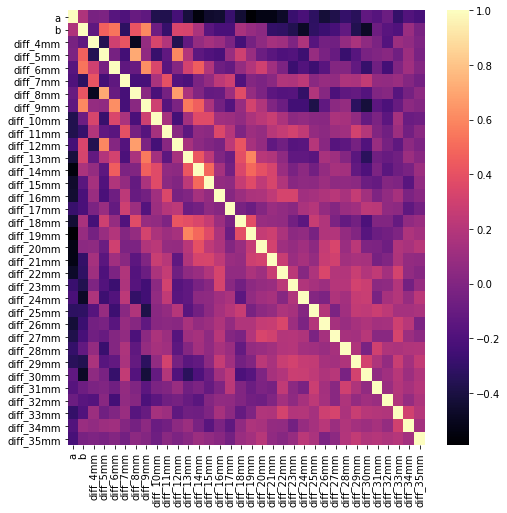

In [42]:
fig = plt.figure(figsize=(8,8))
sns.heatmap(feature_3mm_36mm_scale.corr(),cmap='magma')

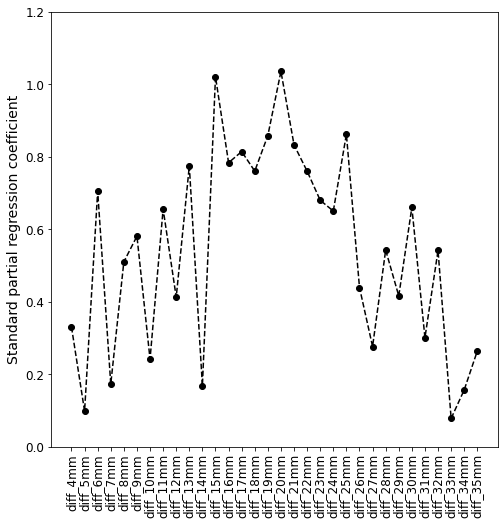

In [147]:

fig = plt.figure(figsize=(8,8))
x_label = (feature_3mm_36mm_scale.columns[2:])
plt.plot(x_label, abs(model_3mm_36mm_6week_pred_coef[1].reshape(-1,1)[2:]),c='k',linestyle='dashed')
plt.scatter(x_label, abs(model_3mm_36mm_6week_pred_coef[1].reshape(-1,1)[2:]),c='k')
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Standard partial regression coefficient',fontsize=14)
plt.ylim(0,1.2)
plt.show()

# fig.savefig('3_36_6week_coef.jpeg')

# 全サンプルモデル

## 6week モデル

In [120]:
# 機械学習モデル作成_6week(全代入 評価)

# 前処理
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler
# 回帰器作成
from sklearn import linear_model
linear = linear_model.LinearRegression()

scaler = StandardScaler()

def linearregression_6(target):
    target = target[0]
    '''
    重回帰分析
    全サンプル代入バージョン
    実測値vs予測値の散布図を返す
    '''
    
#####各週間(6week)ごとにプロットの色を変えて描写する
    y_pred_0 = []
    y_real_0 = []
    y_pred_1 = []
    y_real_1 = []
    y_pred_2 = []
    y_real_2 = []
    y_pred_3 = []
    y_real_3 = []
    y_pred_4 = []
    y_real_4 = []
    y_pred_5 = []
    y_real_5 = []
    y_pred_6 = []
    y_real_6 = []

    for i in range(target.shape[0]):
        if target.index[i][0] == '0':
            y_pred_0.append(target['Predict'][i])
            y_real_0.append(target['Actual'][i])
        elif target.index[i][0] == '1':
            y_pred_1.append(target['Predict'][i])
            y_real_1.append(target['Actual'][i])
        elif target.index[i][0] == '2':
            y_pred_2.append(target['Predict'][i])
            y_real_2.append(target['Actual'][i])
        elif target.index[i][0] == '3':
            y_pred_3.append(target['Predict'][i])
            y_real_3.append(target['Actual'][i])
        elif target.index[i][0] == '4':
            y_pred_4.append(target['Predict'][i])
            y_real_4.append(target['Actual'][i])
        elif target.index[i][0] == '5':
            y_pred_5.append(target['Predict'][i])
            y_real_5.append(target['Actual'][i])
        else:
            y_pred_6.append(target['Predict'][i])
            y_real_6.append(target['Actual'][i])
            
    for i in range(7):
        y_real_temp = [y_real_0,y_real_1,y_real_2,y_real_3,y_real_4,y_real_5,y_real_6][i]
        y_pred_temp = [y_pred_0,y_pred_1,y_pred_2,y_pred_3,y_pred_4,y_pred_5,y_pred_6][i]
        print(f'RMSE_{i}week : {np.sqrt(mean_squared_error(y_real_temp,y_pred_temp))}')
            
#####別々に分けるの終了
    y_real = target['Actual']
    y_pred = target['Predict']
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1,1,1)
    ax.text(0.01,0.85,f'R: {np.corrcoef(y_real, y_pred)[1,0]:.3f}\nRMSE : {np.sqrt(mean_squared_error(y_real,y_pred)):.3f}',
            transform=ax.transAxes,size=28)
    ax.text(0.6,0.05,f'n: {target.shape[0]}',transform=ax.transAxes,size=20)
    #####6週間分を色を変えてプロット
    
    plt.scatter(y_real_0,y_pred_0,marker="D",linewidths=4,c='r',label='0week')
    plt.scatter(y_real_1,y_pred_1,marker="D",linewidths=4,c='orange',label='1week')
    plt.scatter(y_real_2,y_pred_2,marker="D",linewidths=4,c='yellow',label='2week')
    plt.scatter(y_real_3,y_pred_3,marker="D",linewidths=4,c='greenyellow',label='3week')
    plt.scatter(y_real_4,y_pred_4,marker="D",linewidths=4,c='turquoise',label='4week')
    plt.scatter(y_real_5,y_pred_5,marker="D",linewidths=4,c='dodgerblue',label='5week')
    plt.scatter(y_real_6,y_pred_6,marker="D",linewidths=4,c='m',label='6week')
    
    plt.plot([0,28],[0,28],c='k',label='y=x')
    plt.plot([0,28],[3.3,31.3],linestyle='dashed',c='gray')
    plt.plot([0,28],[-3.3,24.7],linestyle='dashed',c='gray')
    plt.ylabel('Predicted Firmness (N)',fontsize=24)
    plt.xlabel('Measured  Firmness (N)',fontsize=24)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlim(18,28)
    plt.ylim(18,28)
    plt.grid(True)
    plt.legend(loc ='lower right',fontsize=14,frameon=False)
    plt.close()

#     print('_______________')
#     for i in range(feature_scale_delay_df.shape[1]):
#         print(f'{feature_scale_delay_df.columns[i]} : {model.coef_[i]:.3f}')
#     print(f'Intercept : {model.intercept_}')
#     print('_______________')
    
    return fig

RMSE_0week : 1.9279963328495442
RMSE_1week : 0.9397666437690725
RMSE_2week : 1.3032562568992079
RMSE_3week : 0.9613805727100113
RMSE_4week : 1.2502007543353348
RMSE_5week : 0.9376405608552285
RMSE_6week : 1.4253539946103535


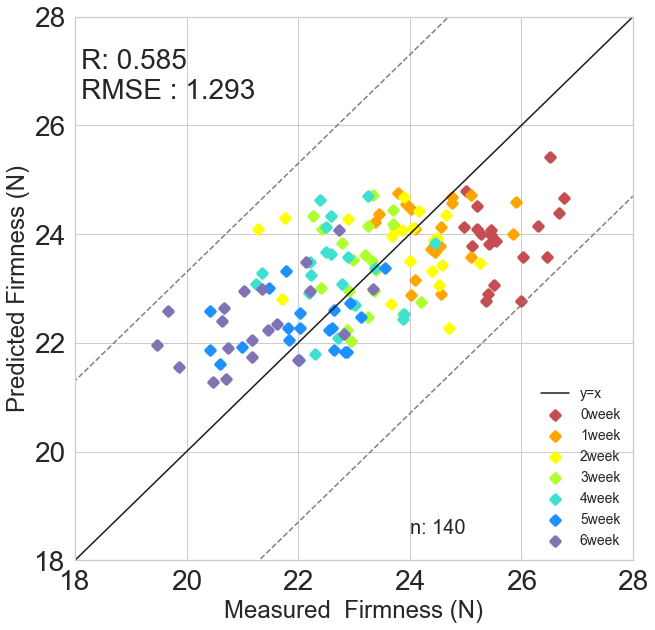

In [122]:
linearregression_6(model_3mm_11mm_6week_pred_coef)
# .savefig('C:/Users/daikidaiki/python_training/paper_reanalysis_211019/model6week.jpg')

## 7week

In [108]:
# 機械学習モデル作成_6week(全代入 評価)

# 前処理
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler
# 回帰器作成
from sklearn import linear_model
linear = linear_model.LinearRegression()

scaler = StandardScaler()

def linearregression_7(target):
    target = target[0]
    '''
    重回帰分析
    全サンプル代入バージョン
    実測値vs予測値の散布図を返す
    '''
    
#####各週間(6week)ごとにプロットの色を変えて描写する
    y_pred_0 = []
    y_real_0 = []
    y_pred_1 = []
    y_real_1 = []
    y_pred_2 = []
    y_real_2 = []
    y_pred_3 = []
    y_real_3 = []
    y_pred_4 = []
    y_real_4 = []
    y_pred_5 = []
    y_real_5 = []
    y_pred_6 = []
    y_real_6 = []
    y_pred_7 = []
    y_real_7 = []

    for i in range(target.shape[0]):
        if target.index[i][0] == '0':
            y_pred_0.append(target['Predict'][i])
            y_real_0.append(target['Actual'][i])
        elif target.index[i][0] == '1':
            y_pred_1.append(target['Predict'][i])
            y_real_1.append(target['Actual'][i])
        elif target.index[i][0] == '2':
            y_pred_2.append(target['Predict'][i])
            y_real_2.append(target['Actual'][i])
        elif target.index[i][0] == '3':
            y_pred_3.append(target['Predict'][i])
            y_real_3.append(target['Actual'][i])
        elif target.index[i][0] == '4':
            y_pred_4.append(target['Predict'][i])
            y_real_4.append(target['Actual'][i])
        elif target.index[i][0] == '5':
            y_pred_5.append(target['Predict'][i])
            y_real_5.append(target['Actual'][i])
        elif target.index[i][0] == '6':
            y_pred_6.append(target['Predict'][i])
            y_real_6.append(target['Actual'][i])
        else:
            y_pred_7.append(target['Predict'][i])
            y_real_7.append(target['Actual'][i])
            
    for i in range(8):
        y_real_temp = [y_real_0,y_real_1,y_real_2,y_real_3,y_real_4,y_real_5,y_real_6,y_real_7][i]
        y_pred_temp = [y_pred_0,y_pred_1,y_pred_2,y_pred_3,y_pred_4,y_pred_5,y_pred_6,y_pred_7][i]
        print(f'RMSE_{i}week : {np.sqrt(mean_squared_error(y_real_temp,y_pred_temp))}')
        
        print(f'Mean of Measured  Firmness {i}week : {np.mean(y_real_temp)}')
        print()
        print(f'Mean of Predicted Firmness {i}week : {np.mean(y_pred_temp)}')
        print()
        print(f'RMSE_{i}week : {np.sqrt(mean_squared_error(y_real_temp,y_pred_temp))}')
        print('----------')
            
#####別々に分けるの終了
    y_real = target['Actual']
    y_pred = target['Predict']
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1,1,1)
    ax.text(0.01,0.85,f'R: {np.corrcoef(y_real, y_pred)[1,0]:.3f}\nRMSE : {np.sqrt(mean_squared_error(y_real,y_pred)):.3f}',
            transform=ax.transAxes,size=28)
    ax.text(0.6,0.05,f'n: {target.shape[0]}',transform=ax.transAxes,size=20)
    #####6週間分を色を変えてプロット
    
    plt.scatter(y_real_0,y_pred_0,marker="D",linewidths=4,c='r',label='0week')
    plt.scatter(y_real_1,y_pred_1,marker="D",linewidths=4,c='orange',label='1week')
    plt.scatter(y_real_2,y_pred_2,marker="D",linewidths=4,c='yellow',label='2week')
    plt.scatter(y_real_3,y_pred_3,marker="D",linewidths=4,c='greenyellow',label='3week')
    plt.scatter(y_real_4,y_pred_4,marker="D",linewidths=4,c='turquoise',label='4week')
    plt.scatter(y_real_5,y_pred_5,marker="D",linewidths=4,c='dodgerblue',label='5week')
    plt.scatter(y_real_6,y_pred_6,marker="D",linewidths=4,c='m',label='6week')
    plt.scatter(y_real_7,y_pred_7,marker="D",linewidths=4,c='pink',label='7week')
    
    plt.plot([0,28],[0,28],c='k',label='y=x')
    plt.plot([0,28],[3.3,31.3],linestyle='dashed',c='gray')
    plt.plot([0,28],[-3.3,24.7],linestyle='dashed',c='gray')
    plt.ylabel('Predicted Firmness (N)',fontsize=24)
    plt.xlabel('Measured  Firmness (N)',fontsize=24)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlim(18,28)
    plt.ylim(18,28)
    plt.grid(True)
    plt.legend(loc ='lower right',fontsize=14,frameon=False)
    plt.close()

#     print('_______________')
#     for i in range(feature_scale_delay_df.shape[1]):
#         print(f'{feature_scale_delay_df.columns[i]} : {model.coef_[i]:.3f}')
#     print(f'Intercept : {model.intercept_}')
#     print('_______________')
    
    return fig




RMSE_0week : 1.8513983707724555
Mean of Measured  Firmness 0week : 25.683056875

Mean of Predicted Firmness 0week : 24.1401445642693

RMSE_0week : 1.8513983707724555
----------
RMSE_1week : 1.355379484874581
Mean of Measured  Firmness 1week : 24.42403875

Mean of Predicted Firmness 1week : 23.683953342693243

RMSE_1week : 1.355379484874581
----------
RMSE_2week : 1.355268428935981
Mean of Measured  Firmness 2week : 23.78816

Mean of Predicted Firmness 2week : 23.529530399064416

RMSE_2week : 1.355268428935981
----------
RMSE_3week : 1.066602998842134
Mean of Measured  Firmness 3week : 23.159775000000003

Mean of Predicted Firmness 3week : 23.245669418068484

RMSE_3week : 1.066602998842134
----------
RMSE_4week : 1.1760967627668217
Mean of Measured  Firmness 4week : 22.717779999999998

Mean of Predicted Firmness 4week : 23.01920743351412

RMSE_4week : 1.1760967627668217
----------
RMSE_5week : 1.0359390478154744
Mean of Measured  Firmness 5week : 22.057785000000003

Mean of Predicted Fi

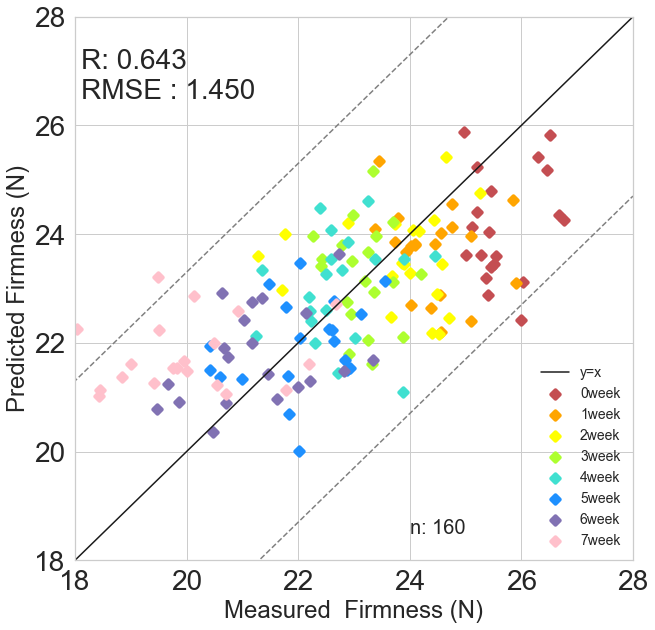

In [109]:
linearregression_7(model_3mm_36mm_7week_pred_coef)
# .savefig('C:/Users/daikidaiki/python_training/paper_reanalysis_211019/model7week.jpg')

# k-foldの各foldにおけるyyplot

C:\Users\daikidaiki\anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\daikidaiki\anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\daikidaiki\anaconda3\lib\site-packages\ipykernel_launcher.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\daikidaiki\anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\daikidaiki\anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\daikidaiki\anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\daikidaiki\anaconda3\lib\site-packages\ipykernel_launcher.py:103: UserWarning: FixedFormatter sho

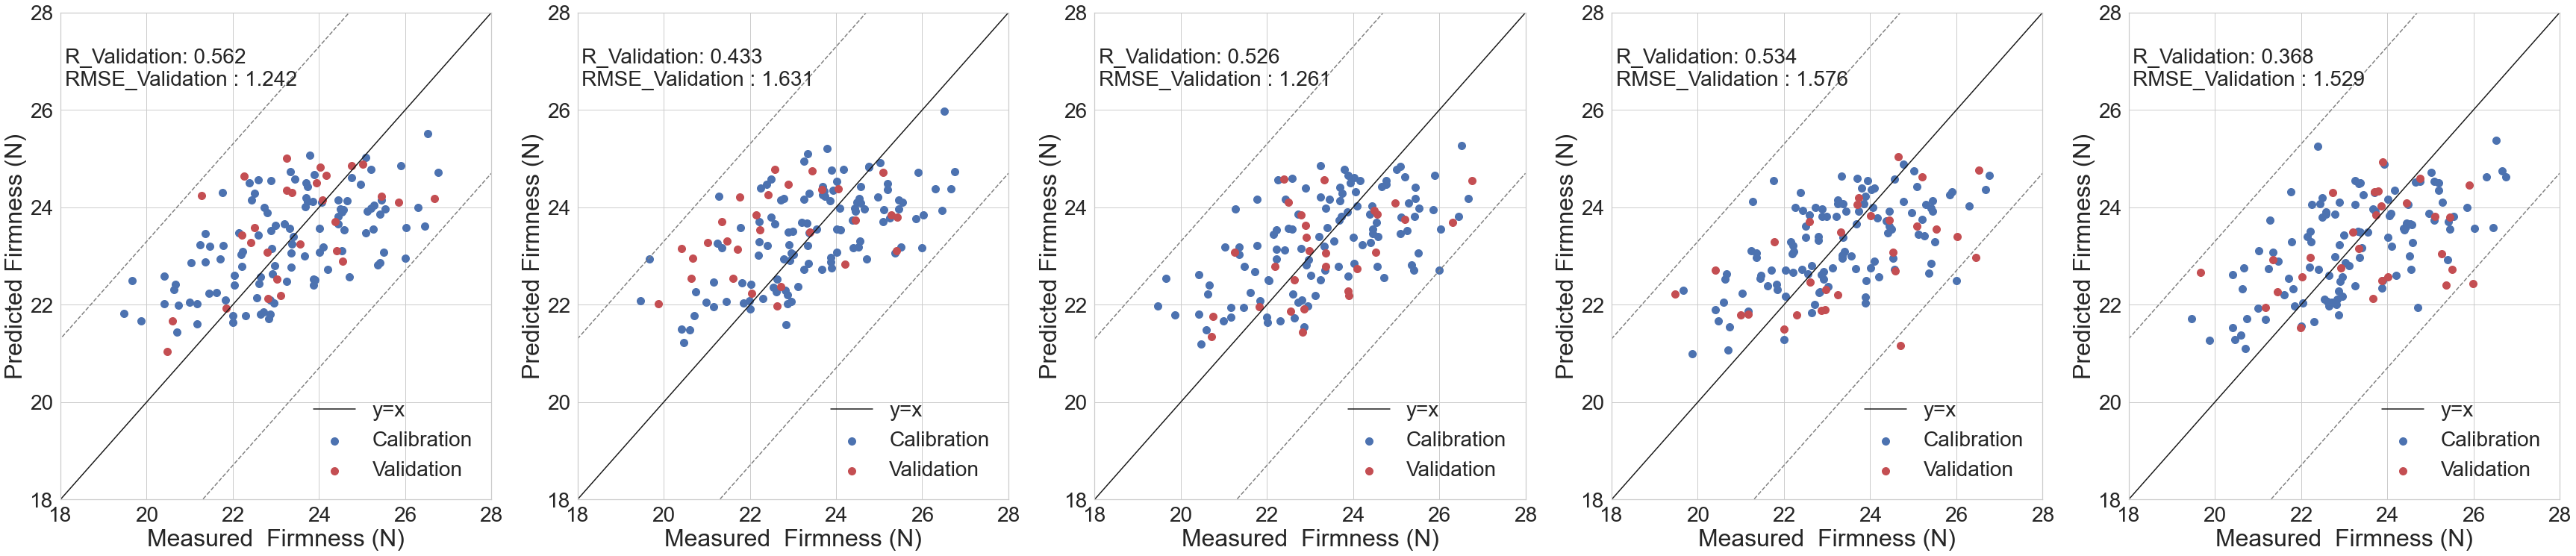

In [128]:
# model_3mm_11mm_6week

train_test_all = model_3mm_11mm_6week[3]

fig = plt.figure(figsize=(60,12))

#add_subplot()でグラフを描画する領域を追加する．引数は行，列，場所
ax1 = fig.add_subplot(1, 5, 1)
ax2 = fig.add_subplot(1, 5, 2)
ax3 = fig.add_subplot(1, 5, 3)
ax4 = fig.add_subplot(1, 5, 4)
ax5 = fig.add_subplot(1, 5, 5)

fold1_train = train_test_all[0]
fold1_test = train_test_all[1]
fold2_train = train_test_all[2]
fold2_test = train_test_all[3]
fold3_train = train_test_all[4]
fold3_test = train_test_all[5]
fold4_train = train_test_all[6]
fold4_test = train_test_all[7]
fold5_train = train_test_all[8]
fold5_test = train_test_all[9]

# Fold1
ax1.scatter(fold1_train.iloc[:,0], fold1_train.iloc[:,1],c='b',label='Calibration',s=100)
ax1.scatter(fold1_test.iloc[:,0],   fold1_test.iloc[:,1],c='r',label='Validation',s=100)

y_real = fold1_test.iloc[:,0].values
y_pred = fold1_test.iloc[:,1].values
ax1.text(0.01,0.85,f'R_Validation: {np.corrcoef(y_real, y_pred)[1,0]:.3f}\nRMSE_Validation : {np.sqrt(mean_squared_error(y_real,y_pred)):.3f}',
        transform=ax1.transAxes,size=28)
# ax1.text(0.6,0.05,f'n: {.shape[0]}',transform=ax1.transAxes,size=16)
    
ax1.plot([0,28],[0,28],c='k',label='y=x')
ax1.plot([0,28],[3.3,31.3],linestyle='dashed',c='gray')
ax1.plot([0,28],[-3.3,24.7],linestyle='dashed',c='gray')
ax1.set_ylabel('Predicted Firmness (N)',fontsize=32)
ax1.set_xlabel('Measured  Firmness (N)',fontsize=32)
ax1.set_xticklabels([18,20,22,24,26,28],fontsize=28)
ax1.set_yticklabels([18,20,22,24,26,28],fontsize=28)
ax1.set_xlim([18, 28])
ax1.set_ylim([18, 28])
ax1.grid(True)
ax1.legend(loc ='lower right',fontsize=28,frameon=False)

# Fold2
ax2.scatter(fold2_train.iloc[:,0], fold2_train.iloc[:,1],c='b',label='Calibration',s=100)
ax2.scatter(fold2_test.iloc[:,0],   fold2_test.iloc[:,1],c='r',label='Validation',s=100)

y_real = fold2_test.iloc[:,0].values
y_pred = fold2_test.iloc[:,1].values
ax2.text(0.01,0.85,f'R_Validation: {np.corrcoef(y_real, y_pred)[1,0]:.3f}\nRMSE_Validation : {np.sqrt(mean_squared_error(y_real,y_pred)):.3f}',
        transform=ax2.transAxes,size=28)
    
ax2.plot([0,28],[0,28],c='k',label='y=x')
ax2.plot([0,28],[3.3,31.3],linestyle='dashed',c='gray')
ax2.plot([0,28],[-3.3,24.7],linestyle='dashed',c='gray')
ax2.set_ylabel('Predicted Firmness (N)',fontsize=32)
ax2.set_xlabel('Measured  Firmness (N)',fontsize=32)
ax2.set_xticklabels([18,20,22,24,26,28],fontsize=28)
ax2.set_yticklabels([18,20,22,24,26,28],fontsize=28)
ax2.set_xlim([18, 28])
ax2.set_ylim([18, 28])
ax2.grid(True)
ax2.legend(loc ='lower right',fontsize=28,frameon=False)

# fold3
ax3.scatter(fold3_train.iloc[:,0], fold3_train.iloc[:,1],c='b',label='Calibration',s=100)
ax3.scatter(fold3_test.iloc[:,0],   fold3_test.iloc[:,1],c='r',label='Validation',s=100)

y_real = fold3_test.iloc[:,0].values
y_pred = fold3_test.iloc[:,1].values
ax3.text(0.01,0.85,f'R_Validation: {np.corrcoef(y_real, y_pred)[1,0]:.3f}\nRMSE_Validation : {np.sqrt(mean_squared_error(y_real,y_pred)):.3f}',
        transform=ax3.transAxes,size=28)
    
ax3.plot([0,28],[0,28],c='k',label='y=x')
ax3.plot([0,28],[3.3,31.3],linestyle='dashed',c='gray')
ax3.plot([0,28],[-3.3,24.7],linestyle='dashed',c='gray')
ax3.set_ylabel('Predicted Firmness (N)',fontsize=32)
ax3.set_xlabel('Measured  Firmness (N)',fontsize=32)
ax3.set_xticklabels([18,20,22,24,26,28],fontsize=28)
ax3.set_yticklabels([18,20,22,24,26,28],fontsize=28)
ax3.set_xlim([18, 28])
ax3.set_ylim([18, 28])
ax3.grid(True)
ax3.legend(loc ='lower right',fontsize=28,frameon=False)

# fold4
ax4.scatter(fold4_train.iloc[:,0], fold4_train.iloc[:,1],c='b',label='Calibration',s=100)
ax4.scatter(fold4_test.iloc[:,0],   fold4_test.iloc[:,1],c='r',label='Validation',s=100)

y_real = fold4_test.iloc[:,0].values
y_pred = fold4_test.iloc[:,1].values
ax4.text(0.01,0.85,f'R_Validation: {np.corrcoef(y_real, y_pred)[1,0]:.3f}\nRMSE_Validation : {np.sqrt(mean_squared_error(y_real,y_pred)):.3f}',
        transform=ax4.transAxes,size=28)
    
ax4.plot([0,28],[0,28],c='k',label='y=x')
ax4.plot([0,28],[3.3,31.3],linestyle='dashed',c='gray')
ax4.plot([0,28],[-3.3,24.7],linestyle='dashed',c='gray')
ax4.set_ylabel('Predicted Firmness (N)',fontsize=32)
ax4.set_xlabel('Measured  Firmness (N)',fontsize=32)
ax4.set_xticklabels([18,20,22,24,26,28],fontsize=28)
ax4.set_yticklabels([18,20,22,24,26,28],fontsize=28)
ax4.set_xlim([18, 28])
ax4.set_ylim([18, 28])
ax4.grid(True)
ax4.legend(loc ='lower right',fontsize=28,frameon=False)

# fold5
ax5.scatter(fold5_train.iloc[:,0], fold5_train.iloc[:,1],c='b',label='Calibration',s=100)
ax5.scatter(fold5_test.iloc[:,0],   fold5_test.iloc[:,1],c='r',label='Validation',s=100)

y_real = fold5_test.iloc[:,0].values
y_pred = fold5_test.iloc[:,1].values
ax5.text(0.01,0.85,f'R_Validation: {np.corrcoef(y_real, y_pred)[1,0]:.3f}\nRMSE_Validation : {np.sqrt(mean_squared_error(y_real,y_pred)):.3f}',
         transform=ax5.transAxes,size=28)
    
ax5.plot([0,28],[0,28],c='k',label='y=x')
ax5.plot([0,28],[3.3,31.3],linestyle='dashed',c='gray')
ax5.plot([0,28],[-3.3,24.7],linestyle='dashed',c='gray')
ax5.set_ylabel('Predicted Firmness (N)',fontsize=32)
ax5.set_xlabel('Measured  Firmness (N)',fontsize=32)
ax5.set_xticklabels([18,20,22,24,26,28],fontsize=28)
ax5.set_yticklabels([18,20,22,24,26,28],fontsize=28)
ax5.set_xlim([18, 28])
ax5.set_ylim([18, 28])
ax5.grid(True)
ax5.legend(loc ='lower right',fontsize=28,frameon=False)


plt.show()


fig.savefig('kfold_compare_10mm.jpg')

C:\Users\daikidaiki\anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\daikidaiki\anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\daikidaiki\anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\daikidaiki\anaconda3\lib\site-packages\ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\daikidaiki\anaconda3\lib\site-packages\ipykernel_launcher.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\daikidaiki\anaconda3\lib\site-packages\ipykernel_launcher.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\daikidaiki\anaconda3\lib\site-packages\ipykernel_launcher.py:104: UserWarning: FixedFormatter sho

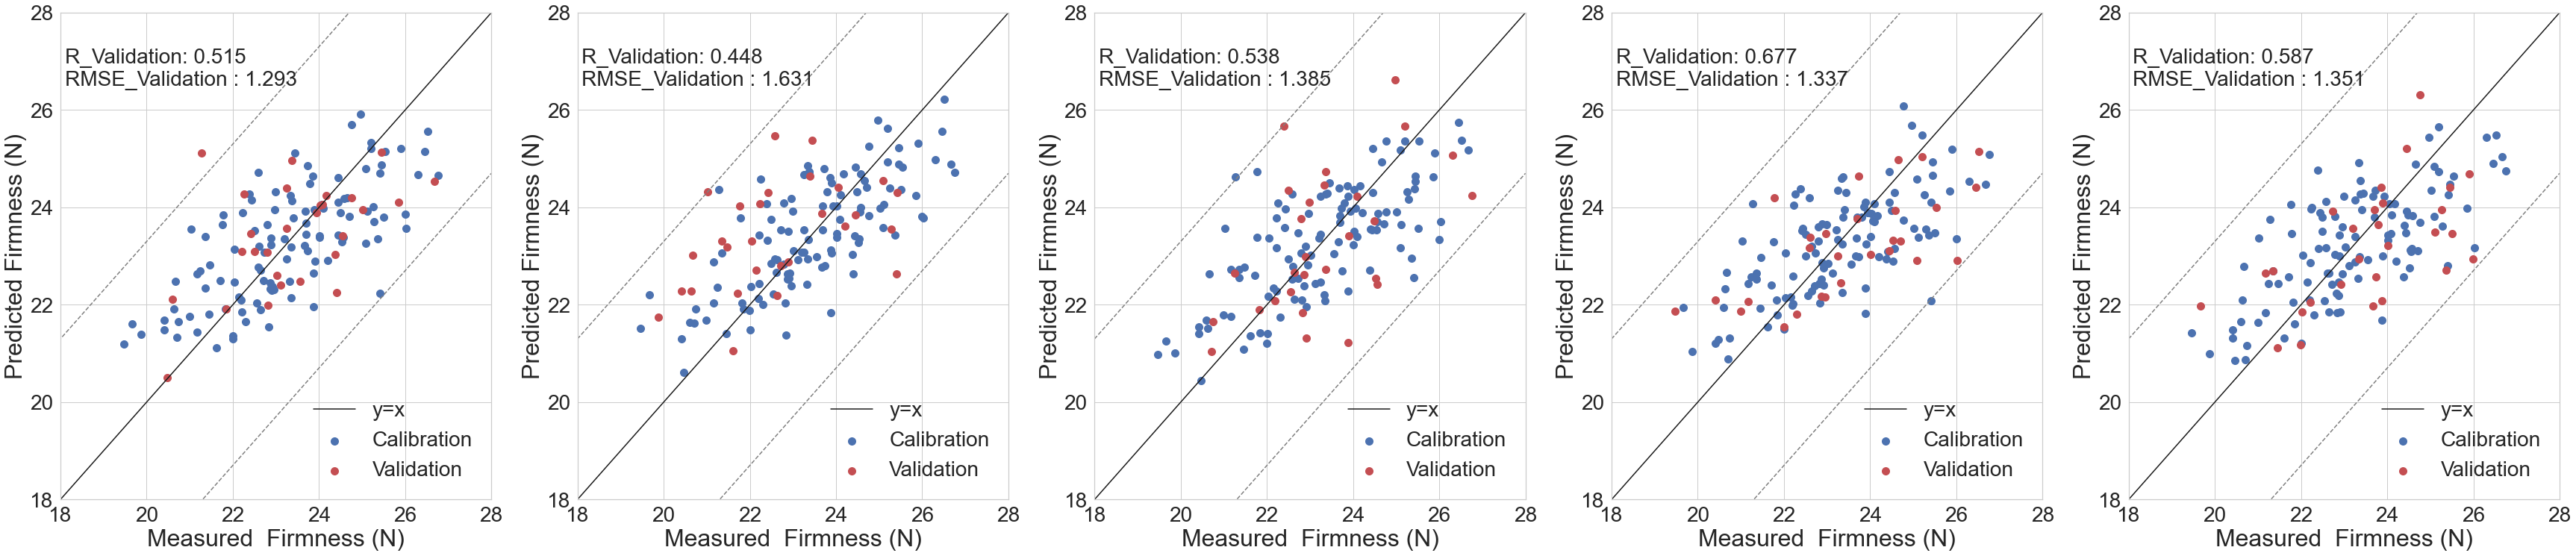

In [129]:
# model_3mm_35mm_6week

train_test_all = model_3mm_36mm_6week[3]


fig = plt.figure(figsize=(60,12))

#add_subplot()でグラフを描画する領域を追加する．引数は行，列，場所
ax1 = fig.add_subplot(1, 5, 1)
ax2 = fig.add_subplot(1, 5, 2)
ax3 = fig.add_subplot(1, 5, 3)
ax4 = fig.add_subplot(1, 5, 4)
ax5 = fig.add_subplot(1, 5, 5)

fold1_train = train_test_all[0]
fold1_test = train_test_all[1]
fold2_train = train_test_all[2]
fold2_test = train_test_all[3]
fold3_train = train_test_all[4]
fold3_test = train_test_all[5]
fold4_train = train_test_all[6]
fold4_test = train_test_all[7]
fold5_train = train_test_all[8]
fold5_test = train_test_all[9]

# Fold1
ax1.scatter(fold1_train.iloc[:,0], fold1_train.iloc[:,1],c='b',label='Calibration',s=100)
ax1.scatter(fold1_test.iloc[:,0],   fold1_test.iloc[:,1],c='r',label='Validation',s=100)

y_real = fold1_test.iloc[:,0].values
y_pred = fold1_test.iloc[:,1].values
ax1.text(0.01,0.85,f'R_Validation: {np.corrcoef(y_real, y_pred)[1,0]:.3f}\nRMSE_Validation : {np.sqrt(mean_squared_error(y_real,y_pred)):.3f}',
        transform=ax1.transAxes,size=28)
# ax1.text(0.6,0.05,f'n: {.shape[0]}',transform=ax1.transAxes,size=16)
    
ax1.plot([0,28],[0,28],c='k',label='y=x')
ax1.plot([0,28],[3.3,31.3],linestyle='dashed',c='gray')
ax1.plot([0,28],[-3.3,24.7],linestyle='dashed',c='gray')
ax1.set_ylabel('Predicted Firmness (N)',fontsize=32)
ax1.set_xlabel('Measured  Firmness (N)',fontsize=32)
ax1.set_xticklabels([18,20,22,24,26,28],fontsize=28)
ax1.set_yticklabels([18,20,22,24,26,28],fontsize=28)
ax1.set_xlim([18, 28])
ax1.set_ylim([18, 28])
ax1.grid(True)
ax1.legend(loc ='lower right',fontsize=28,frameon=False)

# Fold2
ax2.scatter(fold2_train.iloc[:,0], fold2_train.iloc[:,1],c='b',label='Calibration',s=100)
ax2.scatter(fold2_test.iloc[:,0],   fold2_test.iloc[:,1],c='r',label='Validation',s=100)

y_real = fold2_test.iloc[:,0].values
y_pred = fold2_test.iloc[:,1].values
ax2.text(0.01,0.85,f'R_Validation: {np.corrcoef(y_real, y_pred)[1,0]:.3f}\nRMSE_Validation : {np.sqrt(mean_squared_error(y_real,y_pred)):.3f}',
        transform=ax2.transAxes,size=28)
    
ax2.plot([0,28],[0,28],c='k',label='y=x')
ax2.plot([0,28],[3.3,31.3],linestyle='dashed',c='gray')
ax2.plot([0,28],[-3.3,24.7],linestyle='dashed',c='gray')
ax2.set_ylabel('Predicted Firmness (N)',fontsize=32)
ax2.set_xlabel('Measured  Firmness (N)',fontsize=32)
ax2.set_xticklabels([18,20,22,24,26,28],fontsize=28)
ax2.set_yticklabels([18,20,22,24,26,28],fontsize=28)
ax2.set_xlim([18, 28])
ax2.set_ylim([18, 28])
ax2.grid(True)
ax2.legend(loc ='lower right',fontsize=28,frameon=False)

# fold3
ax3.scatter(fold3_train.iloc[:,0], fold3_train.iloc[:,1],c='b',label='Calibration',s=100)
ax3.scatter(fold3_test.iloc[:,0],   fold3_test.iloc[:,1],c='r',label='Validation',s=100)

y_real = fold3_test.iloc[:,0].values
y_pred = fold3_test.iloc[:,1].values
ax3.text(0.01,0.85,f'R_Validation: {np.corrcoef(y_real, y_pred)[1,0]:.3f}\nRMSE_Validation : {np.sqrt(mean_squared_error(y_real,y_pred)):.3f}',
        transform=ax3.transAxes,size=28)
    
ax3.plot([0,28],[0,28],c='k',label='y=x')
ax3.plot([0,28],[3.3,31.3],linestyle='dashed',c='gray')
ax3.plot([0,28],[-3.3,24.7],linestyle='dashed',c='gray')
ax3.set_ylabel('Predicted Firmness (N)',fontsize=32)
ax3.set_xlabel('Measured  Firmness (N)',fontsize=32)
ax3.set_xticklabels([18,20,22,24,26,28],fontsize=28)
ax3.set_yticklabels([18,20,22,24,26,28],fontsize=28)
ax3.set_xlim([18, 28])
ax3.set_ylim([18, 28])
ax3.grid(True)
ax3.legend(loc ='lower right',fontsize=28,frameon=False)

# fold4
ax4.scatter(fold4_train.iloc[:,0], fold4_train.iloc[:,1],c='b',label='Calibration',s=100)
ax4.scatter(fold4_test.iloc[:,0],   fold4_test.iloc[:,1],c='r',label='Validation',s=100)

y_real = fold4_test.iloc[:,0].values
y_pred = fold4_test.iloc[:,1].values
ax4.text(0.01,0.85,f'R_Validation: {np.corrcoef(y_real, y_pred)[1,0]:.3f}\nRMSE_Validation : {np.sqrt(mean_squared_error(y_real,y_pred)):.3f}',
        transform=ax4.transAxes,size=28)
    
ax4.plot([0,28],[0,28],c='k',label='y=x')
ax4.plot([0,28],[3.3,31.3],linestyle='dashed',c='gray')
ax4.plot([0,28],[-3.3,24.7],linestyle='dashed',c='gray')
ax4.set_ylabel('Predicted Firmness (N)',fontsize=32)
ax4.set_xlabel('Measured  Firmness (N)',fontsize=32)
ax4.set_xticklabels([18,20,22,24,26,28],fontsize=28)
ax4.set_yticklabels([18,20,22,24,26,28],fontsize=28)
ax4.set_xlim([18, 28])
ax4.set_ylim([18, 28])
ax4.grid(True)
ax4.legend(loc ='lower right',fontsize=28,frameon=False)

# fold5
ax5.scatter(fold5_train.iloc[:,0], fold5_train.iloc[:,1],c='b',label='Calibration',s=100)
ax5.scatter(fold5_test.iloc[:,0],   fold5_test.iloc[:,1],c='r',label='Validation',s=100)

y_real = fold5_test.iloc[:,0].values
y_pred = fold5_test.iloc[:,1].values
ax5.text(0.01,0.85,f'R_Validation: {np.corrcoef(y_real, y_pred)[1,0]:.3f}\nRMSE_Validation : {np.sqrt(mean_squared_error(y_real,y_pred)):.3f}',
         transform=ax5.transAxes,size=28)
    
ax5.plot([0,28],[0,28],c='k',label='y=x')
ax5.plot([0,28],[3.3,31.3],linestyle='dashed',c='gray')
ax5.plot([0,28],[-3.3,24.7],linestyle='dashed',c='gray')
ax5.set_ylabel('Predicted Firmness (N)',fontsize=32)
ax5.set_xlabel('Measured  Firmness (N)',fontsize=32)
ax5.set_xticklabels([18,20,22,24,26,28],fontsize=28)
ax5.set_yticklabels([18,20,22,24,26,28],fontsize=28)
ax5.set_xlim([18, 28])
ax5.set_ylim([18, 28])
ax5.grid(True)
ax5.legend(loc ='lower right',fontsize=28,frameon=False)


plt.show()

fig.savefig('kfold_compare_35mm.jpg')

# 各期間の予測値のブレ

In [96]:
# 機械学習モデル作成_7week(全代入 評価)

# 前処理
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler
# 回帰器作成
from sklearn import linear_model
linear = linear_model.LinearRegression()

scaler = StandardScaler()

def linearregression_7(feature,target):
    '''
    重回帰分析
    全サンプル代入バージョン
    実測値vs予測値の散布図を返す
    '''
    feature_scale = scaler.fit_transform(feature)
    feature_scale_df = pd.DataFrame(feature_scale,
                                columns = feature.columns,
                                index = feature.index)
# 評価
    
    feature_scale_delay_df = feature_scale_df.drop([],axis = 1)
    model = linear.fit(feature_scale_delay_df.values,target.values.ravel())
    y_pred = model.predict(feature_scale_delay_df)
    y_real = target.values
    
#####各週間(7week)ごとにプロットの色を変えて描写する
    y_pred_0 = []
    y_real_0 = []
    y_pred_1 = []
    y_real_1 = []
    y_pred_2 = []
    y_real_2 = []
    y_pred_3 = []
    y_real_3 = []
    y_pred_4 = []
    y_real_4 = []
    y_pred_5 = []
    y_real_5 = []
    y_pred_6 = []
    y_real_6 = []
    y_pred_7 = []
    y_real_7 = []

    for i in range(target.shape[0]):
        if target.index[i][0] == '0':
            y_pred_0.append(model.predict(feature_scale_delay_df.iloc[i,:].values.reshape(1,-1)))
            y_real_0.append(target[i])
        elif target.index[i][0] == '1':
            y_pred_1.append(model.predict(feature_scale_delay_df.iloc[i,:].values.reshape(1,-1)))
            y_real_1.append(target[i])
        elif target.index[i][0] == '2':
            y_pred_2.append(model.predict(feature_scale_delay_df.iloc[i,:].values.reshape(1,-1)))
            y_real_2.append(target[i])
        elif target.index[i][0] == '3':
            y_pred_3.append(model.predict(feature_scale_delay_df.iloc[i,:].values.reshape(1,-1)))
            y_real_3.append(target[i])
        elif target.index[i][0] == '4':
            y_pred_4.append(model.predict(feature_scale_delay_df.iloc[i,:].values.reshape(1,-1)))
            y_real_4.append(target[i])
        elif target.index[i][0] == '5':
            y_pred_5.append(model.predict(feature_scale_delay_df.iloc[i,:].values.reshape(1,-1)))
            y_real_5.append(target[i])
        elif target.index[i][0] == '6':
            y_pred_6.append(model.predict(feature_scale_delay_df.iloc[i,:].values.reshape(1,-1)))
            y_real_6.append(target[i])
        else:
            y_pred_7.append(model.predict(feature_scale_delay_df.iloc[i,:].values.reshape(1,-1)))
            y_real_7.append(target[i])
            
    
    for i in range(8):
        y_real_temp = [y_real_0,y_real_1,y_real_2,y_real_3,y_real_4,y_real_5,y_real_6,y_real_7][i]
        y_pred_temp = [y_pred_0,y_pred_1,y_pred_2,y_pred_3,y_pred_4,y_pred_5,y_pred_6,y_pred_7][i]
        
        print(f'Mean of Measured  Firmness {i}week : {np.mean(y_real_temp)}')
        print()
        print(f'Mean of Predicted Firmness {i}week : {np.mean(y_pred_temp)}')
        print()
        print(f'RMSE_{i}week : {np.sqrt(mean_squared_error(y_real_temp,y_pred_temp))}')
        print('----------')
            
#####別々に分けるの終了

    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(1,1,1)
    ax.text(0.01,0.85,f'R: {np.corrcoef(y_real,y_pred)[1,0]:.3f}\nRMSE : {np.sqrt(mean_squared_error(y_real,y_pred)):.3f}',
            transform=ax.transAxes,size=28)
    ax.text(0.6,0.05,f'n: {feature.shape[0]}',transform=ax.transAxes,size=20)
    #####7週間分を色を変えてプロット
    
    plt.scatter(y_real_0,y_pred_0,marker="D",linewidths=4,c='tomato',label='0week')
    plt.scatter(y_real_1,y_pred_1,marker="D",linewidths=4,c='sandybrown',label='1week')
    plt.scatter(y_real_2,y_pred_2,marker="D",linewidths=4,c='yellow',label='2week')
    plt.scatter(y_real_3,y_pred_3,marker="D",linewidths=4,c='greenyellow',label='3week')
    plt.scatter(y_real_4,y_pred_4,marker="D",linewidths=4,c='turquoise',label='4week')
    plt.scatter(y_real_5,y_pred_5,marker="D",linewidths=4,c='dodgerblue',label='5week')
    plt.scatter(y_real_6,y_pred_6,marker="D",linewidths=4,c='orchid',label='6week')
    plt.scatter(y_real_7,y_pred_7,marker="D",linewidths=4,c='pink',label='7week')
    
    plt.plot([0,28],[0,28],c='k',label='y=x')
    plt.plot([0,28],[3.3,31.3],linestyle='dashed',c='gray')
    plt.plot([0,28],[-3.3,24.7],linestyle='dashed',c='gray')
    plt.ylabel('Predicted Firmness (N)',fontsize=24)
    plt.xlabel('Measured  Firmness (N)',fontsize=24)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlim(18,28)
    plt.ylim(18,28)
    plt.grid(True)
    plt.legend(loc ='lower right',fontsize=14,frameon=False)
    plt.close()

    print('_______________')
    for i in range(feature_scale_delay_df.shape[1]):
        print(f'{feature_scale_delay_df.columns[i]} : {model.coef_[i]:.3f}')
    print(f'Intercept : {model.intercept_}')
    print('_______________')
    
    return fig




In [107]:
linearregression_7(feature_3mm_36mm_scale,pd.Series(firmness_all))

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

# Appendix : 一般化線形モデルとの精度比較

In [397]:
# 線形回帰

X = sm.add_constant(feature_3mm_36mm_scale.iloc[:140,:])
model = sm.OLS(target_6week.values, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     2.819
Date:                Mon, 01 Nov 2021   Prob (F-statistic):           2.89e-05
Time:                        10:28:01   Log-Likelihood:                -218.47
No. Observations:                 140   AIC:                             506.9
Df Residuals:                     105   BIC:                             609.9
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.2584      0.115    201.622      0.0

C:\Users\daikidaiki\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [403]:
# 一般化線形回帰
glm_binom = sm.GLM(target_6week.values, X, amily=sm.families.Poisson())
res = glm_binom.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  140
Model:                            GLM   Df Residuals:                      105
Model Family:                Gaussian   Df Model:                           34
Link Function:               identity   Scale:                          1.7697
Method:                          IRLS   Log-Likelihood:                -218.47
Date:                Mon, 01 Nov 2021   Deviance:                       185.82
Time:                        10:36:25   Pearson chi2:                     186.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.2584      0.115    201.622      0.000      23.032      23.485
a             -5.6691      8.443     -0.671      0.502     -22.216      10.878
b             -0.9122      0.286     -3.189      0.001      -1.473      -0.352
diff_4mm       0.3298      0.270      1.223      0.221      -0.199       0.858
diff_5mm       0.0978      0.484      0.202      0.840      -0.850       1.046
diff_6mm      -0.7045      0.607     -1.161      0.246      -1.894       0.485
diff_7mm      -0.1724      0.588     -0.293      0.769      -1.325       0.980
diff_8mm      -0.5098      0.816     -0.625      0.532      -2.110       1.090
diff_9mm      -0.5805      0.906     -0.641      0.522      -2.356       1.195
diff_10mm     -0.2412      0.661     -0.365      0.715      -1.537       1.055
diff_11mm     -0.6554      0.836     -0.784      0.433      -2.295       0.984
diff_12mm     -0.4121      1.084     -0.380      0.704      -2.536       1.712
diff_13mm     -0.7741      1.126     -0.688      0.492      -2.980       1.432
diff_14mm     -0.1676      1.038     -0.161      0.872      -2.202       1.867
diff_15mm     -1.0204      0.952     -1.072      0.284      -2.887       0.846
diff_16mm     -0.7832      0.970     -0.807      0.420      -2.685       1.118
diff_17mm     -0.8140      1.041     -0.782      0.434      -2.855       1.227
diff_18mm     -0.7601      1.177     -0.646      0.518      -3.067       1.547
diff_19mm     -0.8583      1.143     -0.751      0.453      -3.098       1.382
diff_20mm     -1.0352      1.039     -0.997      0.319      -3.071       1.000
diff_21mm     -0.8324      1.085     -0.767      0.443      -2.959       1.294
diff_22mm     -0.7598      0.966     -0.786      0.432      -2.654       1.134
diff_23mm     -0.6795      1.015     -0.670      0.503      -2.669       1.310
diff_24mm     -0.6499      1.047     -0.621      0.535      -2.702       1.402
diff_25mm     -0.8617      1.053     -0.819      0.413      -2.925       1.202
diff_26mm     -0.4388      0.894     -0.491      0.624      -2.192       1.314
diff_27mm     -0.2760      0.792     -0.349      0.727      -1.828       1.276
diff_28mm     -0.5421      0.634     -0.855      0.393      -1.785       0.701
diff_29mm     -0.4157      0.717     -0.580      0.562      -1.822       0.990
diff_30mm     -0.6600      0.720     -0.917      0.359      -2.071       0.751
diff_31mm     -0.3004      0.487     -0.617      0.538      -1.255       0.655
diff_32mm     -0.5411      0.445     -1.216      0.224      -1.413       0.331
diff_33mm      0.0775      0.370      0.209      0.834      -0.648       0.803
diff_34mm     -0.1565      0.275     -0.569      0.569      -0.696       0.383
diff_35mm      0.2636      0.168      1.567      0.117      -0.066       0.593
==============================================================================
""

In [408]:
# sklearnでGLM可能

from sklearn.linear_model import PoissonRegressor

glm = PoissonRegressor(
                        alpha=0,  # ペナルティ項
                        fit_intercept=True,  # 切片
                        max_iter=300,  # ソルバーの試行回数
                      )
glm.fit(feature_3mm_11mm_scale.iloc[:140,:],target_6week)

y_hat = glm.predict(feature_3mm_11mm_scale.iloc[:140,:])
 

C:\Users\daikidaiki\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [411]:
temp = pd.concat([target_6week,pd.DataFrame(y_hat,index = target_6week.index)],axis=1)

In [414]:
temp.corr()[0]

frimness    0.582489
0           1.000000
Name: 0, dtype: float64

In [416]:
res = model_3mm_11mm_6week_pred_coef[0]['Actual'] - model_3mm_11mm_6week_pred_coef[0]['Predict']

<AxesSubplot:xlabel='Actual'>

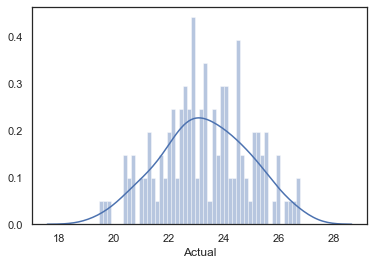

In [422]:
sns.distplot( model_3mm_11mm_6week_pred_coef[0]['Actual'],bins=50)

# 線形重回帰 (Statsmodel)

In [10]:
X = sm.add_constant(feature_3mm_36mm_scale.iloc[:140,:])
y = firmness_all.iloc[:140,:]
results = sm.OLS(y,X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               frimness   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     2.819
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           2.89e-05
Time:                        15:03:02   Log-Likelihood:                -218.47
No. Observations:                 140   AIC:                             506.9
Df Residuals:                     105   BIC:                             609.9
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.2584      0.115    201.622      0.0

C:\Users\daikidaiki\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
